# 1. Preparing the data

Here we use a sample dataset that anyone can freely download from LinkedIn Dataset. Here is the url: https://nubela.co/blog/sample-data-for-linkdb/

In [2]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 59.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=f9008e3a8e7a54ffa6aebf2ff263402f4ac0ce045310040b7db381e9faf9fbcc
  Stored in directory: /root/.cache/pip/wheels/6a/67/f8/9cf1a8ff87e0b37f738769df49cc142a655489a6d27b68089f
Successfully built langdetect


In [24]:
!pip install fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.2/232.2 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 22.3 MB/s eta 0:00:00


In [3]:
import json
from langdetect import detect
import re
import string
import pandas as pd

In [4]:
data_json = json.load(open('data.json'))

In [5]:
bios = [person["summary"] for person in data_json if "summary" in person.keys()]

In [6]:
bios = [bio for bio in bios if (bio != None)]

In [7]:
def is_empty_str(s):
    b = [c == " " for c in list(s)]
    return all(b)

In [8]:
def clean_str(s):
    new_str = re.sub(r'http\S+', '', s) # remove urls
    new_str = re.sub(r'\S*@\S*\s?', '', new_str) # remove emails
    new_str = ''.join(s for s in new_str if ord(s)>31 and ord(s)<126)
    return new_str

In [9]:
def is_only_punc_dig(s):
    return all(c.isdigit() or c in string.punctuation or c == ' ' for c in s)

In [10]:
cleaned_bios = bios.copy()

for bio in bios:
    if is_empty_str(bio):
        if bio in cleaned_bios:
            cleaned_bios.remove(bio)
    else:
        cleaned = clean_str(bio)
        if is_only_punc_dig(cleaned):
            cleaned_bios.remove(bio)
        else:
            i = cleaned_bios.index(bio)
            cleaned_bios[i] = cleaned

In [11]:
# check if cleaned_bios has any bug texts

'''
for bio in cleaned_bios:
    try:
        detect(bio)
    except:
        print(bio, '\ntest:', is_only_punc_dig(bio))
'''

"\nfor bio in cleaned_bios:\n    try:\n        detect(bio)\n    except:\n        print(bio, '\ntest:', is_only_punc_dig(bio))\n"

In [12]:
bios = [bio for bio in cleaned_bios if detect(bio) == 'en']

In [13]:
len(bios)

16412

In [19]:
# save this file

df = pd.DataFrame({'linkedin_bios': bios})
df.to_csv("bios.csv")

In [61]:
bios[:3]

['CP Furniture Services is based in the GTA and specializes in large and small office seating repairs and installations in Ontario and all over North America. We primarily work with seating manufacturers and dealers providing on-site repairs and retrofits for seating in office, health care and government environments. We take pride in our " small footprint " approach and are happiest when people say they had no idea we were even there.',
 'by trade a setter since 1983.completed machining d.e.p. extensive 1800 hr. courses ,took c.n.c. courses.engraver on computerized system,since 8 years',
 "Our Services Include:  Neurofeedback In-Person Sessions, Private-Mobile Sessions & Home-Rental Units.When was the last time you trained your brain?NeurOptimal Neurofeedback is a non-invasive, safe integrative approach to better health, mental well-being and overall wellness.  Neurofeedback provides brain-training that aims to reduce general dysregulations in the brain.  The NeurOptimal Neurofeedback

In [20]:
len(bios)

16412

# 2. Import pre-trained model

In [21]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [22]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [17]:
ids = tokenizer.encode('I’m an enthusiastic business management')
ids

[40, 447, 247, 76, 281, 21848, 1597, 4542]

In [18]:
tokenizer.decode(ids)

'I’m an enthusiastic business management'

In [19]:
import torch

In [20]:
t = torch.LongTensor(ids)[None]
preds = model.generate(t)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.9/dist-packages/transformers/generation_utils.py:1202: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [21]:
preds.shape,preds[0]

(torch.Size([1, 20]),
 tensor([   40,   447,   247,    76,   281, 21848,  1597,  4542, 17028,    13,
           314,  1101,   257,  1263,  4336,   286,   262,  1664,   290,   314]))

In [22]:
tokenizer.decode(preds[0].numpy())

"I’m an enthusiastic business management consultant. I'm a big fan of the company and I"

# 3. Bridge the gap using fastai

In [25]:
from fastai.text.all import *

In [26]:
l = len(bios)
train_len = int(l*0.7)
train_len

11488

In [27]:
l - train_len

4924

In [28]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks)).to(device).long()
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [29]:
splits = [range_of(train_len), list(range(train_len, l))]
tls = TfmdLists(bios, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [30]:
tls.train[0],tls.valid[0]

(tensor([ 8697, 34937,  8089,  6168,   318,  1912,   287,   262, 30807,   290,
         29786,   287,  1588,   290,  1402,  2607, 24800, 20097,   290, 26162,
           287, 10553,   290,   477,   625,  2258,  2253,    13,   775,  7525,
           670,   351, 24800, 11372,   290, 15737,  4955,   319,    12, 15654,
         20097,   290, 12175, 21013,   329, 24800,   287,  2607,    11,  1535,
          1337,   290,  1230, 12493,    13,   775,  1011, 11293,   287,   674,
           366,  1402, 24713,   366,  3164,   290,   389, 49414,   618,   661,
           910,   484,   550,   645,  2126,   356,   547,   772,   612,    13],
        device='cuda:0'),
 tensor([28516,   319, 13741,   318,   616,  7506,    13,   314,   423,   587,
         20200,   284,   423,   262,  5885,   284,  7301,  1180,  3006,   286,
           262, 17420,   290,  6431,  3725,   290,  4678,   422,   845,  1180,
         22582,    25,   422,  3227,   284,  4200,    11,   422,  4226, 12660,
           290,  1628,  2

In [31]:
show_at(tls.train, 0)

CP Furniture Services is based in the GTA and specializes in large and small office seating repairs and installations in Ontario and all over North America. We primarily work with seating manufacturers and dealers providing on-site repairs and retrofits for seating in office, health care and government environments. We take pride in our " small footprint " approach and are happiest when people say they had no idea we were even there.


In [32]:
show_at(tls.valid, 0)

Working on Film is my passion. I have been fortunate to have the possibility to explore different areas of the Industry and gather knowledge and skills from very different perspectives: from production to sales, from script evaluation and project development to having a better understanding of the market. I have been able to learn from the immense effort it means to write a script and the energies employed in creating a Film, as well as discover the savvy and strategic mindset required to be able to put the Films out in the world and the best ways to go about it.Through my experience I have also discovered that I thrive when given the opportunity to help and connect with other people. Be it by helping on the matchmaking for potential partners or simply by having continuous discussions on the way to develop an idea. I enjoy meeting new people who are passionate and want to create something meaningful and authentic. My goal is to work on exciting and challenging projects, in an environme

In [33]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [34]:
dls.show_batch(max_n=2)

,text,text_
0,"I am a FGA certified gemologist (FGA - Gemmological Association of Great Britain), EGM certified gems and jewelry appraiser. I own business Jewelry Olga designing and making pearl jewelry in Montreal, Canada.Our mission is to create one-of-a-kind pearl jewelry having value and impeccable quality. Pearl jewelry created by Jewelry Olga is known for its interesting designs and fresh solutions. I describe our product as ""Elegant Chic at Jewelry Olga"".Why pearls? Because pearl jewelry has always been a symbol of elegance, prestige and class.Moreover, being a gemologist, I guarantee the quality of the pearls and other gem stones that we use for our creations. I love pearls, know all about them, and, by following the latest tendencies on the pearl market, I offer my clients The Best.Designer pearl jewelry is always an amazing gift for any occasion - anniversary, wedding, Christmas, St. Valentine's Day, Mother's Day","am a FGA certified gemologist (FGA - Gemmological Association of Great Britain), EGM certified gems and jewelry appraiser. I own business Jewelry Olga designing and making pearl jewelry in Montreal, Canada.Our mission is to create one-of-a-kind pearl jewelry having value and impeccable quality. Pearl jewelry created by Jewelry Olga is known for its interesting designs and fresh solutions. I describe our product as ""Elegant Chic at Jewelry Olga"".Why pearls? Because pearl jewelry has always been a symbol of elegance, prestige and class.Moreover, being a gemologist, I guarantee the quality of the pearls and other gem stones that we use for our creations. I love pearls, know all about them, and, by following the latest tendencies on the pearl market, I offer my clients The Best.Designer pearl jewelry is always an amazing gift for any occasion - anniversary, wedding, Christmas, St. Valentine's Day, Mother's Day"
1,"working with Fortune 500accounts B2B sales experience in SaaS organizations by managing a pipeline and closing 6-figure contractsIm a Certified AML, Risk and Intelligence professional with over 15 years experience providing governance consulting, risk advisory and investigative services worldwide.I work with private and public entities, local and international governments on risk mitigation and investigative matters.I have experience overseeing and managing thousands of projects in the areas of Due Diligence, Enhanced Due Diligence, Litigation Support, Intellectual Property and Corporate / AML / Anti-fraud Investigations. I lead day-to-day operations of teams predominantly focused on international EDD engagements and investigations with resources located across the globe.I have also conducted extensive Government program audit/reviews, focusing on operational policies, compliance and procedures, workflow analysis, operational support and system recommendations.Prior to moving to North America, I provided investigation and consulting services to law firms, corporations and intelligence agencies in Europe.Java Software Engineer who solving","with Fortune 500accounts B2B sales experience in SaaS organizations by managing a pipeline and closing 6-figure contractsIm a Certified AML, Risk and Intelligence professional with over 15 years experience providing governance consulting, risk advisory and investigative services worldwide.I work with private and public entities, local and international governments on risk mitigation and investigative matters.I have experience overseeing and managing thousands of projects in the areas of Due Diligence, Enhanced Due Diligence, Litigation Support, Intellectual Property and Corporate / AML / Anti-fraud Investigations. I lead day-to-day operations of teams predominantly focused on international EDD engagements and investigations with resources located across the globe.I have also conducted extensive Government program audit/reviews, focusing on operational policies, compliance and procedures, workflow analysis, operational support and system recommendations.Prior to

# 4. Fine-tuning the model

In [35]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [36]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [37]:
learn.validate()

(#2) [4.134922504425049,62.48474884033203]

The perplexity score is 62.48, which is good for this vocab size

SuggestedLRs(valley=0.0002754228771664202)

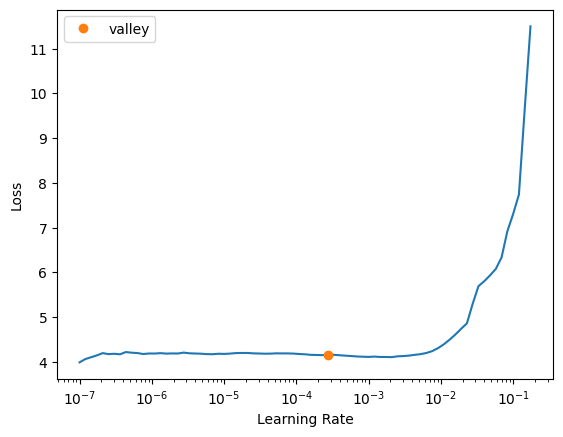

In [38]:
learn.lr_find()

Suggested learning rate is a bit lower than 1e-4

In [39]:
learn.fit_one_cycle(1, 4e-4)

epoch,train_loss,valid_loss,perplexity,time
0,3.672414,3.832401,46.173260,01:52


Perplexity decreased to 31.13! It's a huge improvement

In [40]:
prompt = "I'm a business professional with 10 years of"

In [41]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 9])

In [46]:
preds = learn.model.generate(inp, max_length=70, num_beams=5, temperature=1.5)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [47]:
tokenizer.decode(preds[0].cpu().numpy())

"I'm a business professional with 10 years of experience working in the financial services industry. I have a strong background in financial analysis, financial reporting, and financial reporting. I have a strong background in financial analysis, financial reporting, and financial reporting. I have a strong background in financial analysis, financial reporting, and financial reporting. I have a strong background"

It looks awesome!

In [48]:
prompt = "I'm a content creator"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape
preds = learn.model.generate(inp, max_length=100, num_beams=5, temperature=1.5)
tokenizer.decode(preds[0].cpu().numpy())

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"I'm a content creator with a passion for the intersection of technology and the human experience. I'm passionate about the intersection of technology and the human experience. I'm passionate about the intersection of technology and the human experience. I'm passionate about the intersection of technology and the human experience. I'm passionate about the intersection of technology and the human experience. I'm passionate about the intersection of technology and the human experience. I'm passionate about the intersection of technology and the human experience. I'm passionate about"

SuggestedLRs(valley=0.0002290867705596611)

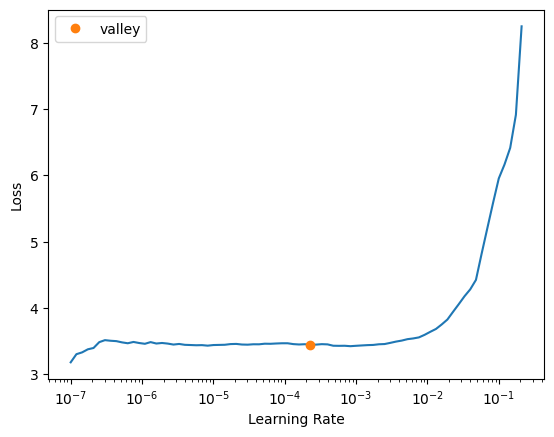

In [49]:
learn.lr_find()

In [50]:
learn.fit_one_cycle(1, 4e-4)

epoch,train_loss,valid_loss,perplexity,time
0,3.496351,3.831819,46.146381,01:52


In [58]:
prompt = "I've founded"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape
preds = learn.model.generate(inp, max_length=75, num_beams=10, temperature=1.5)
tokenizer.decode(preds[0].cpu().numpy())

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"I've founded and led a number of startups in the tech space. I'm currently working on a few of them, but I'm looking forward to connecting with people from all walks of life to learn more about what it takes to be a successful entrepreneur.I am a recent graduate from the University of Texas at Dallas with a Bachelors of Science in Computer Science. I"

In [71]:
prompt = "Dedicated Film professional"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape
preds = learn.model.generate(inp, max_length=50, num_beams=10, temperature=1.5)
tokenizer.decode(preds[0].cpu().numpy())

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Dedicated Film professional with a demonstrated history of working in the film industry. Skilled in Film Production, Film Editing, Film Production, and Film Production. Strong arts and design professional with a Bachelor of Arts (B.A.) focused in Film'

They seem to be working a bit in the beginning but soon fall into repeated words. I think this is the extend of this model. Let's add more data to it to see if we can improve on that

SuggestedLRs(valley=2.511886486900039e-05)

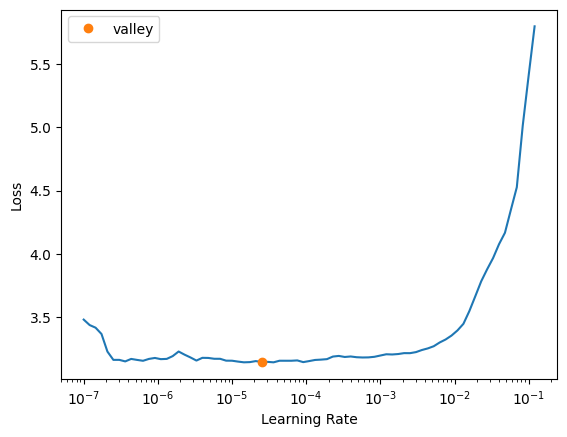

In [72]:
learn.lr_find()

In [73]:
learn.fit_one_cycle(1, 5e-5)

epoch,train_loss,valid_loss,perplexity,time
0,3.171449,3.850465,47.014935,01:53


In [75]:
prompt = "Dedicated Film professional"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape
preds = learn.model.generate(inp, max_length=50, num_beams=10, temperature=1.5)
tokenizer.decode(preds[0].cpu().numpy())

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Dedicated Film professional with a demonstrated history of working in the film and television industry. Skilled in Photography, Film Production, Photography, and Videography. Strong arts and design professional with a Bachelor of Arts (B.A.) focused in Film'

In [76]:
prompt = "Machine Learning Engineer"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape
preds = learn.model.generate(inp, max_length=50, num_beams=10, temperature=1.5)
tokenizer.decode(preds[0].cpu().numpy())

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Machine Learning Engineer with a demonstrated history of working in the information technology and services industry. Skilled in Python, Java, C, C++, and JavaScript. Strong information technology professional with a Bachelor of Science (B.S.) focused in Computer Science'

In [88]:
prompt = "Passionate Animator"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape
preds = learn.model.generate(inp, max_length=60, num_beams=10, temperature=1.5)
tokenizer.decode(preds[0].cpu().numpy())

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Passionate Animator with a demonstrated history of working in the animation industry. Skilled in Sketching, Animation, Animation, and Visual Effects. Strong arts and design professional with a Bachelor of Fine Arts (BFA) focused in Fine Arts and Design from University of California, Irvine.Experienced'

In [113]:
prompt = "Working on degree"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape
preds = learn.model.generate(inp, max_length=50, num_beams=10, temperature=1.5)
tokenizer.decode(preds[0].cpu().numpy())

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Working on degree in Computer Science from Nanyang Technological University (NTU). I am currently working as a Software Engineer at Amazon Web Services (AWS). I am currently working as a Software Engineer at Amazon Web Services (AWS). I'

Seems to perform well when the length of paragraph is 30 - 60 words. Pretty good!

SuggestedLRs(valley=3.0199516913853586e-05)

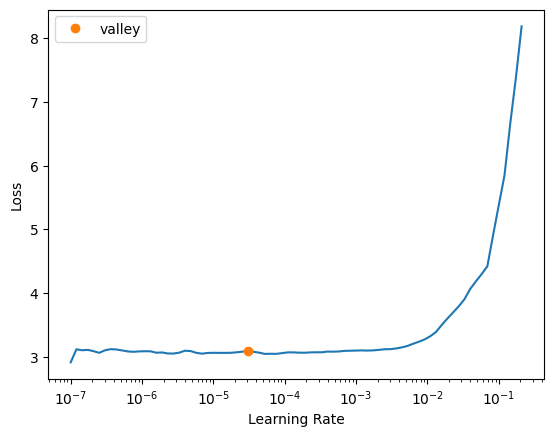

In [114]:
learn.lr_find()z

In [115]:
learn.fit_one_cycle(1, 1e-5)

epoch,train_loss,valid_loss,perplexity,time
0,3.087823,3.857399,47.342052,01:58


In [66]:
learn.fit_one_cycle(1, 4e-4)

Dedicated risk management consultant with experience in accounting, finance and client relationship settings.Respected builder and leader within team work, committed, driven and energetic. I have developed skills in financial control & analysis. I strive for new challenges and corporate adventures!
